In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

## Define and Collect Trajectories of the Nonlinear System

In [2]:
def nonlinear_system(t,X):
    
    # specify rate of change of each state
    dx1dt = X[0]**2
    
    # roll up states into a numpy array
    dXdt = np.asarray([dx1dt])
    
    return dXdt

In [172]:
# initial condition
initial_state = [0.01]
dt = 0.01
final_time = 120
t_vec = np.arange(0,final_time,dt)
tspan = np.asarray([0,final_time])

states = solve_ivp(nonlinear_system, tspan, initial_state, t_eval = t_vec, method = "DOP853")

t = states.t
x = states.y
x = x[0,:]

(10001,) (10001,)


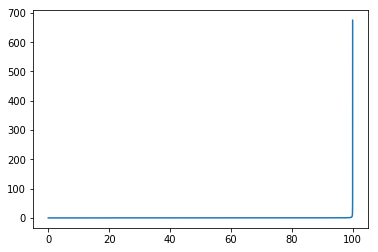

In [173]:
# plot trajectories
plt.plot(t,x)
print(t.shape,x.shape)

## Perform DMD with and without Time Delay Embeddings and Visualize Mode Spectrum

In [174]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

(1000, 6999)


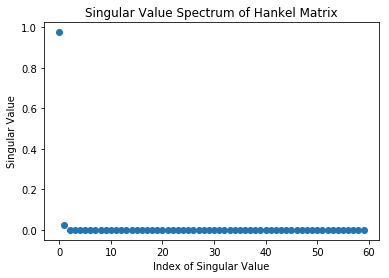

In [191]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 1000 # Number of shift-stacked rows
r = 60  # rank of HAVOK model
num_states = 1
H = np.zeros((stackmax,X.shape[0]-stackmax))

for k in range(0,stackmax,1):
    H[k,:] = X[k:-(stackmax-k)]
    
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

S = S[:r]

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)


In [192]:
latent_vars = np.where(S>1)[0]
print(latent_vars)
print(H.shape)

[0 1]
(1000, 6999)


In [193]:
S

array([5.47305340e+01, 1.36447510e+00, 2.85942868e-02, 4.75889874e-04,
       8.61016588e-05, 8.46821670e-06, 3.79596391e-06, 1.61968786e-06,
       8.87743260e-07, 4.93898097e-07, 3.08894062e-07, 1.96940155e-07,
       1.34295381e-07, 9.31068479e-08, 6.74994732e-08, 4.95944290e-08,
       3.75839303e-08, 2.87944426e-08, 2.25851403e-08, 1.78738004e-08,
       1.43975942e-08, 1.16848559e-08, 9.62097663e-09, 7.97202762e-09,
       6.68127690e-09, 5.63035023e-09, 4.79086722e-09, 4.09592402e-09,
       3.52966374e-09, 3.05442944e-09, 2.66156806e-09, 2.32768579e-09,
       2.04775467e-09, 1.80729318e-09, 1.60348981e-09, 1.42664082e-09,
       1.27525877e-09, 1.14273973e-09, 1.02831925e-09, 9.27312665e-10,
       8.39495748e-10, 7.61405739e-10, 6.93003073e-10, 6.31760450e-10,
       5.77846602e-10, 5.29292222e-10, 4.86243564e-10, 4.47271806e-10,
       4.12580961e-10, 3.81037438e-10, 3.52757008e-10, 3.26948817e-10,
       3.03727455e-10, 2.82471254e-10, 2.63206908e-10, 2.45531413e-10,
      

In [206]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 10 # enter the value of r
Phi_delay, Lambda_delay, b_delay = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay)

(1000, 6998) (1000, 6998)
Phi = [[ 0.00561017-0.03056938j  0.00561017+0.03056938j -0.0278876 -0.01491667j
  ...  0.02430679+0.j         -0.03025577+0.j
   0.03512718+0.j        ]
 [ 0.00626604-0.03042859j  0.00626604+0.03042859j -0.02771587-0.0152415j
  ...  0.02431867+0.j         -0.03025841+0.j
   0.03511949+0.j        ]
 [ 0.00691248-0.0302785j   0.00691248+0.0302785j  -0.02754092-0.01556327j
  ...  0.02433054+0.j         -0.03026105+0.j
   0.03511181+0.j        ]
 ...
 [-0.01920729-0.02397432j -0.01920729+0.02397432j -0.0155115 +0.0275543j
  ...  0.03955032+0.j         -0.03300954+0.j
   0.02824207+0.j        ]
 [-0.01866751-0.02434605j -0.01866751+0.02434605j -0.01581518+0.02736334j
  ...  0.03956964+0.j         -0.03301242+0.j
   0.02823589+0.j        ]
 [-0.01811321-0.02471047j -0.01811321+0.02471047j -0.01611676+0.02716765j
  ...  0.03958897+0.j         -0.03301531+0.j
   0.02822971+0.j        ]] 

Lambda = [[0.99982164+0.01808317j 0.        +0.j         0.        +0.j
  0.    

In [207]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([r,X_delay.shape[1]])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*t_vec[i])
    
X_dmd_delay = np.dot(Phi_delay,time_dynamics_delay)

print(time_dynamics_delay.shape,Phi_delay.shape,X_dmd_delay.shape)

(10, 6998) (1000, 10) (1000, 6998)


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [208]:
time_dynamics_delay.shape[1]

6998

/home/ashwin/.local/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


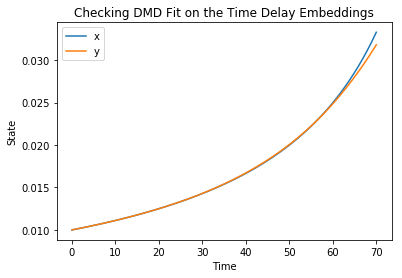

In [209]:
X_dmd_delay_model = X_dmd_delay[:,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[:end_delay],label='x')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

print()

## Compare against the Linearized System

In [182]:
def linear_system(t,Y,params):

    mu = params[0]
    lam = params[1]
    
    dy1dt = mu*Y[0]
    dy2dt = lam*Y[1]-lam*Y[2]
    dy3dt = 2*mu*Y[2]
    
    dYdt = np.asarray([dy1dt,dy2dt,dy3dt])
    
    return dYdt
    

In [183]:
def intrinsic_coords(x):
    y0 = x[0]
    y1 = x[1]
    y2 = x[0]**2
    
    y = np.asarray([y0,y1,y2])
    
    return y


In [ ]:
initial_state_linear = intrinsic_coords(initial_state)

states_lin = solve_ivp(linear_system, tspan, initial_state_linear, t_eval = t_delay, args = (params,))

t_lin = states_lin.t
x_lin = states_lin.y

In [ ]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

In [ ]:
# plot to compare the DMD modes to the actual data
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("ODE Evolution of Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

In [ ]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()